# real_shape_optimization

> Fix isogonal modes and get real space vertices by minimizing metric energy under (soft?) tension constraint.


# to do:

- check for errors by writing a function that checks polygon intersection: is any point in any other polygon? use half-space check to do this. also function for self-intersection. see https://stackoverflow.com/questions/471962/how-do-i-efficiently-determine-if-a-polygon-is-convex-non-convex-or-complex/45372025#45372025

- wrap up the simulation time iteration with additional functions. clean up the energy function to make it more modular (i.e. enable switching out the function which calculates energy for each face).

- plotting function to color cells, or triangles by `dict`

In [ ]:
#| default_exp isogonal_face

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

from math import floor, ceil

import sys

from copy import deepcopy

from collections import Counter

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import autograd.numpy as anp  # Thinly-wrapped numpy
from autograd import grad as agrad

from scipy.sparse import csc_matrix

In [ ]:
#| notest

# reimport stuff if required after updating the code elsewhere

import importlib

## this is how you re-import a module
#importlib.reload(nameOfModule)

## this is how you reload a specific function or class
#import X
#reload(X)
#from X import Y  # or * for that matter

## matplotlib slider plots

Structure: create a _callback function_ which does the plotting you want, depending on parameter. Then use generator, e.g. `widgets.interact` with a slider for each argument, to create user interfaces.

For optimization, one can rewrite the callback function to do as little as possible, e.g. by re-using the figure created. Ignore for now...

Plotting different times can be done easily this way by passing index to data array as callback argument


https://notebook.community/seewhydee/ntuphys_nb/jupyter_tutorial/jupyter_tutorial_02

In [ ]:
#| export

import ipywidgets as widgets

Other slides types exist also, eg. `IntSlider`, or `ToggleButton`. See https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html. You can also write a somewhat optimized function, where minimal amount of work is done in the callback function, and the figure is only created once.

In [ ]:
%matplotlib inline
# actually the arguments for the slider can be specified in a much more concise form as well

def series(dots, colr):
    a,b=[],[]
    for i in range(dots):
        a.append(np.random.randint(1,100))
        b.append(np.random.randint(1,100))
    plt.scatter(a,b, c=colr)
    return
widgets.interact(series, dots=(1,100,1), colr=["red","orange","brown"]);

interactive(children=(IntSlider(value=50, description='dots', min=1), Dropdown(description='colr', options=('r…

In [ ]:
%matplotlib inline

#### Animation

we can also done HMTL5 animations in place. This is nice, I don't have to jump to terminal to render with fffmpeg.

In [ ]:
#| export
from matplotlib import animation, rc
rc('animation', html='html5')

In [ ]:
## try to simplify. I would like to avoid using the set_data type update and redraw the entire plot
# from scratch at each time. This is wasteful, but it would be a pain to reuse line objects when drawing
# meshes!


# create empty lists for the x and y data
x = []
y = []

# create the figure and axes objects
fig = plt.figure(facecolor="white")


# function that draws each frame of the animation
def animate(i):
    pt = np.random.randint(1,9) # grab a random integer to be the next y-value in the animation
    x.append(i)
    y.append(pt)

    plt.cla()
    plt.plot(x, y)
    plt.xlim([0,20])
    plt.ylim([0,10])
    if i == 19: # hack....
        plt.close()
    
# run the animation
anim = animation.FuncAnimation(fig, animate, frames=20, interval=500, repeat=False,
                               )
anim.save('plots/basic_animation_no_reuse.mp4', fps=4,) #extra_args=['-vcodec', 'libx264'])
# must not "print" animation before saving !

# best open not with vlc which seems to have some strange problems with it

### Related: notebook for navigating (static) plots dynamically

notebook plots all stuff in a single cell. so if you execute plotting commands in other cells, it shows up in the same window.

<IPython.core.display.Javascript object>


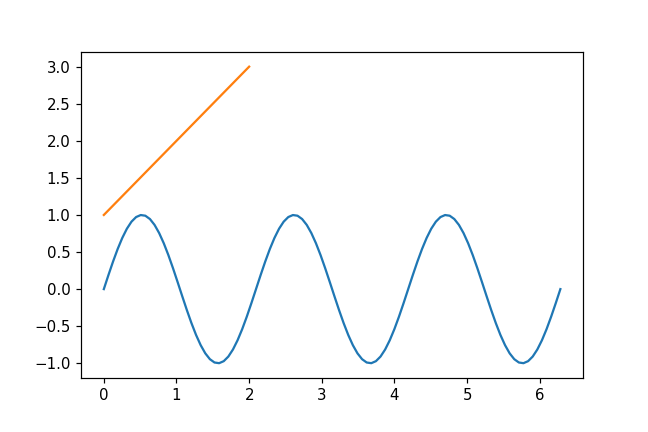

[<matplotlib.lines.Line2D>]

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots()

x = np.linspace(0, 2*np.pi, 100)
y = np.sin(3*x)
ax.plot(x, y)

[<matplotlib.lines.Line2D>]

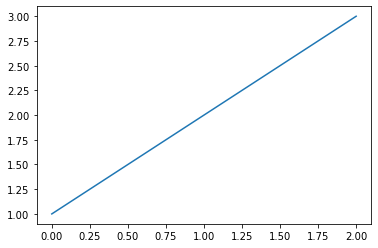

In [ ]:
%matplotlib inline

plt.plot([1,2,3])

## Definition of the cell shape tensor

Now based off of the sides

In [ ]:
#| export

def polygon_area(pts):
    """area of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(pts[:,0]*anp.roll(pts[:,1], 1, axis=0) - anp.roll(pts[:,0], 1, axis=0)*pts[:,1], axis=0)/2

def polygon_perimeter(pts):
    """perimeter of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(anp.linalg.norm(pts-anp.roll(pts, 1, axis=0), axis=1))

def get_vertex_energy(pts, A0=1, P0=1, mod_shear=0, mod_bulk=1):
    """Get vertex style energy"""
    return mod_bulk*(polygon_area(pts)-A0)**2 + mod_shear*(polygon_perimeter(pts)-P0)**2

In [ ]:
poly = np.array([[-0.45, -0.31],
           [-0.54,  0.36],
           [ 0.09,  0.61],
           [ 0.54,  0.22],
           [ 0.51, -0.37],
           [ 0.07, -0.61]])

poly_repeat = poly = np.array([[-0.45, -0.31],
           [-0.54,  0.36],
           [ 0.09,  0.61],
           [ 0.54,  0.22],
           [ 0.51, -0.37],
           [ 0.07, -0.61], [ 0.07, -0.61], [ 0.07, -0.61]])


In [ ]:
poly_stacked = np.stack(50*[poly_repeat], axis=-1)

In [ ]:
polygon_area(poly_stacked)

array([0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471])

In [ ]:
polygon_area(poly), polygon_area(poly_repeat)

(0.9471, 0.9471)

## Code for mesh energy

In [ ]:
#| export

# new plotting functions
@patch
def labelplot(self: HalfEdgeMesh, vertex_labels=True, face_labels=True,
                     halfedge_labels=False, cell_labels=False):
    """for debugging purposes, a fct to plot a trimesh with labels attached"""
    if face_labels:
        for fc in self.faces.values():
            centroid = np.mean([he.vertices[0].coords for he in fc.hes], axis=0)
            plt.text(*centroid, str(fc._fid), color="k")
    if vertex_labels:
        for v in self.vertices.values():
            plt.text(*(v.coords+np.array([0,.05])), str(v._vid),
                     color="tab:blue", ha="center")
    if cell_labels:
        for v in self.vertices.values():
            nghbs = v.get_face_neighbors()
            if not (None in nghbs):
                center = np.mean([fc.dual_coords for fc in nghbs], axis=0)
                plt.text(*(center), str(v._vid),
                         color="tab:blue", ha="center")
    if halfedge_labels:
        for he in self.hes.values():
            if he.duplicate:
                centroid = np.mean([v.coords for v in he.vertices], axis=0)
                plt.text(*centroid, str(he._heid), color="tab:orange")

In [ ]:
#| export

@patch
def cellplot(self: HalfEdgeMesh, alpha=1, set_lims=False):
    """Plot based on primal positions. Now fast because of use of LineCollection"""
    face_keys = sorted(self.faces.keys())
    face_key_dict = {key: ix for ix, key in enumerate(face_keys)}
    face_key_dict[None] = None
    primal_face_list = []
    for v in self.vertices.values():
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            face = [face_key_dict[fc._fid] for fc in neighbors]
            face.append(face[0])
            primal_face_list.append(face)

    pts = np.stack([self.faces[key].dual_coords for key in face_keys])
    lines = [[pts[v] for v in fc] for fc in primal_face_list]
    
    #fig, ax = plt.subplots()
    plt.gca().add_collection(LineCollection(lines, color="k", alpha=alpha))
    if set_lims:
        plt.gca().set_xlim([pts[:,0].min(), pts[:,0].max()])
        plt.gca().set_ylim([pts[:,1].min(), pts[:,1].max()])

In [ ]:
#| export

@patch
def get_face_neighbors(self: Vertex):
    """Get face neighbors of vertex"""
    neighbors = []
    start_he = self.incident[0]
    he = start_he
    returned = False
    while not returned:
        neighbors.append(he.face)
        he = he.nxt.twin
        returned = (he == start_he)
    return neighbors

@patch
def set_centroid(self: HalfEdgeMesh):
    """Set dual positions to triangle centroid"""
    for fc in self.faces.values():
        vecs = []
        returned = False
        start_he = fc.hes[0]
        he = start_he
        while not returned:
            vecs.append(he.vertices[0].coords)
            he = he.nxt
            returned = (he == start_he)
        fc.dual_coords = np.mean(vecs, axis=0)

@patch
def transform_dual_vertices(self: HalfEdgeMesh, trafo: Union[Callable, NDArray[Shape["2, 2"], Float]]):
    for fc in self.faces.values():
        if isinstance(trafo, Callable):
            fc.dual_coords = trafo(fc.dual_coords)
        else:
            fc.dual_coords = trafo.dot(fc.dual_coords)

## Code for primal energy minimization

Need to ``serialize'' half edge mesh for rapid optimization

In [ ]:
#| export

@patch
def dual_vertices_to_initial_cond(self: HalfEdgeMesh):
    """Format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    dual_vertex_vector = np.stack([self.faces[key].dual_coords for key in face_keys]).T
    return np.hstack([dual_vertex_vector[0], dual_vertex_vector[1]])
       
@patch
def initial_cond_to_dual_vertices(self: HalfEdgeMesh, x0):
    """Reverse of format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
    dual_vertex_vector = np.stack([x, y], axis=1)
    return {key: val for key, val in zip(face_keys, dual_vertex_vector)}


## Angle constraint energy

In [ ]:
#| export

@patch
def get_angle_deviation(self: HalfEdgeMesh):
    """Angle between primal and dual edges. For diagnostics"""
    angle_deviation = {}

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None):
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            primal_edge = he.face.dual_coords - he.twin.face.dual_coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = primal_edge / np.linalg.norm(primal_edge)        
            angle_deviation[he._heid] = np.dot(dual_edge, primal_edge)**2
    return angle_deviation

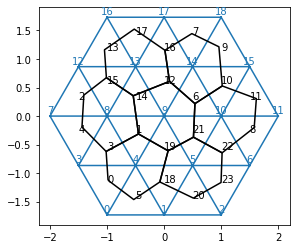

In [ ]:
# iterate over edges and ensure angle primal | dual = 0

mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.05))

mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
fc = mesh.faces[19]
neighbors = [he.twin.face for he in fc.hes]
neighbors

[Face(fid=1, dual_coords=[-0.4, -0.3], hes=[3, 4, 5]),
 Face(fid=18, dual_coords=[-0.1, -1.2], hes=[56, 54, 55]),
 Face(fid=21, dual_coords=[0.5, -0.4], hes=[64, 65, 63])]

In [ ]:
np.stack([np.round(fc.dual_coords, decimals=2)  for fc in mesh.vertices[9].get_face_neighbors()])

array([[-0.45, -0.31],
       [-0.54,  0.36],
       [ 0.09,  0.61],
       [ 0.54,  0.22],
       [ 0.51, -0.37],
       [ 0.07, -0.61]])

In [ ]:
sum(mesh.get_angle_deviation().values()) / 2

0.41992395386367837

## Energy function

In [ ]:
#| export

@patch
def is_bdr(self: Face):
    """True if face touches bdr. Check all vertices. Does any have an incident edge with None face?"""
    verts = [he.vertices[1] for he in self.hes]
    return any([any([he.face is None for he in v.incident]) for v in verts])

In [ ]:
def get_boundary_faces(msh):
    """Get indices of boundary faces"""
    bdr_faces = []
    bdr_start = next(he for he in msh.hes.values() if he.face is None).twin.nxt
    he = bdr_start
    returned = False
    while not returned:
        bdr_faces.append(he.face._fid)
        if he.nxt.twin.face.is_bdr():
            he = he.nxt.twin
        else:
            he = he.prev.twin
        returned = (he == bdr_start)
    return bdr_faces

In [ ]:
get_boundary_faces(mesh)

[0, 3, 4, 2, 15, 13, 17, 16, 7, 9, 10, 11, 8, 22, 23, 20, 18, 5]

In [ ]:
#| export

@patch
def get_primal_energy_fct_vertices(self: HalfEdgeMesh, mod_bulk=1, mod_shear=1e-3, angle_penalty=1e2,
                                   rest_shape=None, reg_bulk=0, A0=sqrt(3)/2,
                                   max_valence=10,):
    """Get function to compute primal energy from primal vertices."""
    if rest_shape is None:
        rest_shape = np.eye(2) if metric else 2*np.eye(2)

    # stuff for the shape tensor energy
    face_list = []    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    face_key_dict[None] = None
    for fc in self.faces.values():
        neighbors = [he.twin.face for he in fc.hes]
        if not (None in neighbors):
            face_list.append(anp.array([face_key_dict[x._fid] for x in neighbors]
                                      +[face_key_dict[fc._fid]]))
    face_list = anp.array(face_list).T
    n_faces = len(self.faces)

    # stuff for the vertex-energy-based regularization
    cell_list = []
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            cell = [face_key_dict[fc._fid] for fc in neighbors]
            try:
                cell = anp.pad(cell, (0, max_valence-len(cell)), mode="edge")
            except ValueError:
                print(f"celll with more than {max_valence} nghbs, increase max_valence")
            cell_list.append(cell)
    cell_list = anp.array(cell_list)
    
    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]]
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)
    
    # breaking translational invariance.
    center = anp.mean([v.coords for v in self.vertices.values()], axis=0)
    
    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        pts = anp.stack([x, y], axis=-1)
        # shape energy - can be either vertex style or shape tensor based
        edges = anp.stack([pts[a]-pts[face_list[3]] for a in face_list[:3]])
        lengths = anp.linalg.norm(edges, axis=-1)
        units = (edges.T/lengths.T).T        
        tensors = 2*anp.einsum('efi,efj->fij', edges, units) - rest_shape
        E_shape = (mod_shear*anp.sum(tensors**2)
                   + mod_bulk*anp.sum((tensors[:,0,0]+tensors[:,1,1])**2))
        # regularize with the vertex model energy
        poly = anp.stack([[x[i], y[i]] for i in cell_list.T]) # shape (max_valence, 2, n_cells)
        E_vertex = reg_bulk*anp.sum((polygon_area(poly)-A0)**2)
        # angle penalty
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]]
        e_primal = (e_primal.T/anp.linalg.norm(e_primal, axis=-1)).T
        E_angle = angle_penalty * anp.mean(anp.einsum('ei,ei->e', e_primal, e_dual)**2)
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        
        return  E_angle + E_shape + E_vertex + E_trans
    
    return get_E, agrad(get_E)

## Minimization, constrained  - let's try to find a minimal example of bad behavior

Optimization. Need to improve speed.

- use metric
- vectorize cell area term

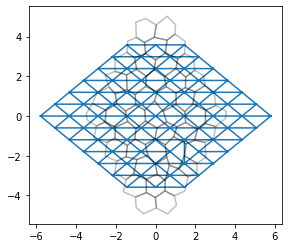

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=13, nx=9)

mesh.flip_edge(151)  # this creates an example of an edge with != 6 sides. e.g. 9
mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.06)) #shear_mat(1.2)@x)
mesh.transform_vertices(shear_mat(1.45)) # 1.31almost 90 degree angles

mesh.cellplot(alpha=.25)
mesh.triplot()
#mesh.labelplot()

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
mod_bulk = 1
mod_shear = 0.05
angle_penalty = 10

A0 = sqrt(3)/2
reg_bulk = 0 #.05 #0.05
reg_shear = 0

cell_shape_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear, "angle_penalty": angle_penalty,
                   "A0": A0, "reg_bulk": reg_bulk}

In [ ]:
#%%time
x0 = mesh.dual_vertices_to_initial_cond()
get_E, jac = mesh.get_primal_energy_fct_vertices(**cell_shape_args)
# this step is fast, 10ms maybe

In [ ]:
%%timeit
_ = get_E(x0);
# post vectorization - 900mus. pre vectorization: 16ms.

# metric = False: 910mus
# metric = True: 800 mus

# angle penalty computation costs very little

KeyboardInterrupt: 

In [ ]:
%%timeit
_ = jac(x0);
# post vectorization: 7ms.  pre vectorization: 173ms

# metric = False: 8ms. Not that different#
# metric = True: 7.5ms

6.63 ms ± 706 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%time
sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", tol=5*1e-2,
                        options={"maxiter": 500})
#print(sol["message"])
print(get_E(sol["x"]))

# by far the longest is the vertex-energy term. with vertex energy = 7s, without = .7 s
# using metric = False yields similar time as metric= False. Increasing shear modulus makes
# things a little slower also. Here is where metric=True is really better.

# jacobian brings huge improvement. BFGS is best.

# large mesh: pre vectorization, 50s. Post vectorization. 4.5s. 10x speedup.

# energy pre vec: 18.1 ->  0.05. 
# energy post: 18.1 -> 0.05.

# metric = False. -> 21s.
# metric = False and oriented = True -> bad behavior. 

# smaller mesh for optimization testing
# CG for metric = false: 23.6
# BFGS for metric = false: 4.7

# tol = 1e-1 -> energy =.25, .8s. this is not good enough!
# tol = 5*1e-2 -> energy =.05, 3s with maxiter 250
# might be better to set max iter. to around 200

0.05755965395275904
CPU times: user 14.9 s, sys: 8.47 s, total: 23.4 s
Wall time: 7.1 s


In [ ]:
%%time
new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh.faces.items():
    val.dual_coords = new_coord_dict[key]
# this step is fast also

CPU times: user 786 µs, sys: 354 µs, total: 1.14 ms
Wall time: 499 µs


In [ ]:
np.quantile(list(mesh.get_primal_edge_lens().values()), q=.1)
# reg = 0.05 -> edge lengths .37. reg 0: edge length .15. reg .01: .4 ...

1.5191593352435362e-05

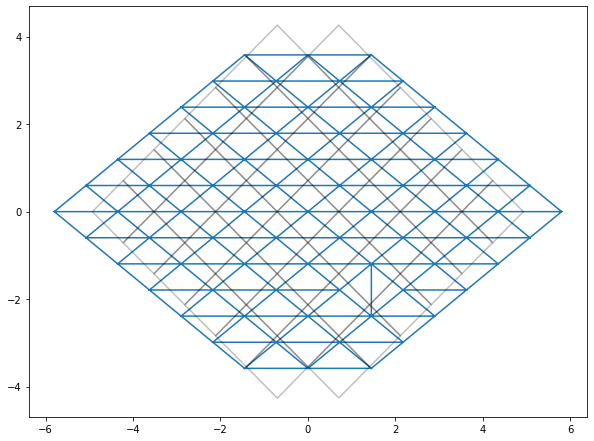

In [ ]:
# completely correct - but can have problem at boundary if there was an edge flip!
# in this case, ever self-intersection can occur.

# actuall;y it already does here!

fig = plt.figure(figsize=(10, 10))

mesh.cellplot(alpha=.25)
mesh.triplot()
#mesh.labelplot() # halfedge_labels=True

#pts = np.stack([fc.dual_coords for fc in mesh.vertices[10].get_face_neighbors()])
#plt.scatter(*pts.T, c="r")

plt.gca().set_aspect("equal", adjustable="box");

### We will need to compute primal lengths to flip edges

Might use the same technique as above to get the line orientation right (i.e. check whether parallel or anti-parallel with the centroid connector), which might be better numerically.

Indexed by `_heid`

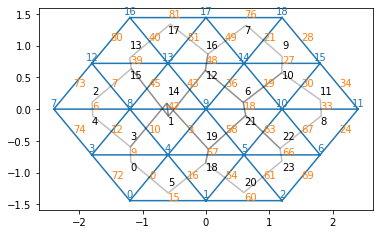

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_rest_lengths() 
mesh.transform_vertices(shear_mat(1.2)) # 1.31almost 90 degree angles
mesh.set_voronoi()
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.02))

# create self-intersection
mesh.faces[14].dual_coords, mesh.faces[1].dual_coords = (mesh.faces[1].dual_coords, mesh.faces[14].dual_coords)


mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot(halfedge_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
#| export

@patch
def get_primal_edge_lens(self: HalfEdgeMesh, oriented=True):
    len_dict = {}
    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            primal_vec = he.face.dual_coords-he.twin.face.dual_coords
            length = np.linalg.norm(primal_vec)
            if oriented:
                centroid_vec = (np.mean([x.vertices[0].coords for x in he.face.hes], axis=0)
                                -np.mean([x.vertices[0].coords for x in he.twin.face.hes], axis=0))
                length *= np.sign(np.dot(primal_vec, centroid_vec))
            len_dict[he._heid] = length
    return len_dict

In [ ]:
primal_lengths = mesh.get_primal_edge_lens(oriented=False)
argmin = min(primal_lengths, key=primal_lengths.get)
argmin, primal_lengths[argmin]

(39, 0.16914018179552312)

In [ ]:
primal_lengths = mesh.get_primal_edge_lens(oriented=True)
argmin = min(primal_lengths, key=primal_lengths.get)
argmin, primal_lengths[argmin]

(42, -0.20627533197285627)

### Various helper functions for the iteration over time steps

Just to make things more compact

In [ ]:
#| export

# for re-setting primal vertex positions after intercalation
def rotate_about_center(x, angle=pi/2):
    """Rotate pts about center. x.shape = (n_pts, 2)"""
    center = np.mean(x, axis=0)
    return (x-center)@rot_mat(angle)+np.mean(x, axis=0)

In [ ]:
#| export

@patch
def flatten_triangulation(self: HalfEdgeMesh, tol=1e-3):
    """flatten triangulation"""
    get_E, grd = self.get_energy_fct()
    x0 = self.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="CG", jac=grd, tol=tol)
    if sol["status"] !=0:
        print("Triangulation optimization failed")
        print(sol["message"])
    new_coord_dict = self.initial_cond_to_vertices(sol["x"])
    for key, val in self.vertices.items():
        val.coords = new_coord_dict[key]
    self.set_rest_lengths()

In [ ]:
@patch
def reset_rest_passive_flip(self: HalfEdgeMesh, e: HalfEdge):
    """Reset rest length and passive tensions of flipped he according to myosin inheritance"""
    twin = e.twin
    rest_pre = (e.rest+twin.rest)/2
    rest_neighbors = (e.nxt.rest+e.prev.rest+twin.nxt.rest+twin.prev.rest)/4
    e.rest = np.linalg.norm(e.vertices[0].coords - e.vertices[1].coords)
    e.passive = (rest_pre+e.rest)-2*rest_neighbors
    twin.rest, twin.passive = (e.rest, e.passive)
    print(e.rest, e.passive)
    
def excitable_dt_post(Ts, Tps, k=1, m=2):
    """Time derivative of tensions under excitable tension model with constrained area,
    with passive tension for post intercalation"""
    dT_dt = (Ts-Tps)**m - k*Tps
    dTp_dt = -k*Tps
    area_jac = sides_area_jac(Ts-Tps)
    area_jac /= norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)
    return dT_dt, dTp_dt

# originally from notebook 01 - go back and update !

In [ ]:
def euler_step(msh, dt=.005, k=.25, m=2):
    # euler step
    for fc in msh.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        dT_dt, dTp_dt = excitable_dt_post(Ts, Tps, k=k, m=m)
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp

In [ ]:
def optimize_cell_shape(msh, energy_fct_kwargs=None, tol=1e-3):
    """primal optimization"""
    energy_fct_kwargs = dict() if energy_fct_kwargs is None else energy_fct_kwargs
    get_E, jac = msh.get_primal_energy_fct_vertices(**energy_fct_kwargs)
    x0 = msh.dual_vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", tol=tol)
    if sol["status"] !=0:
        print(i, "Cell shape optimization failed", sol["message"])
    new_coord_dict = msh.initial_cond_to_dual_vertices(sol["x"])
    for key, val in msh.faces.items():
        val.dual_coords = new_coord_dict[key]


In [ ]:
def temp_plot(msh):
    msh.cellplot()
    msh.triplot()
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.gca().set_aspect("equal", adjustable="box")

## Full simulation, as example

### notes:

- not too bad using non-metric non-oriented edges! Eventually still develops some self-intersection.

-> try regularizing using vertex energy! Works well. Problem is really the 

In [ ]:
## Make the length function oriented!

In [ ]:
# set parameters. 

m = 2
k = 20

dt = .0025 #0.005
n_steps = 200

epsilon_l = .05

mod_bulk = 1
mod_shear = 0.05
angle_penalty = 10

A0, P0 = (sqrt(3)/2, 2*sqrt(3))
reg_bulk = 0.05
reg_shear = 0
regularization = "per-cell" # per-cell

forbid_reflip = 10 # do not re-flip an edge flipped in the last $n timesteps

metric = True # False
oriented  = False # False

cell_shape_args = {"metric": metric, "oriented": oriented,
                   "mod_bulk": mod_bulk, "mod_shear": mod_shear, "angle_penalty": angle_penalty,
                   "A0": A0, "P0": P0, "reg_bulk": reg_bulk, "reg_shear": reg_shear,
                   "regularization": regularization}

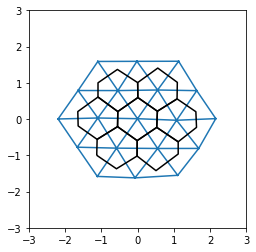

In [ ]:
%matplotlib inline
mesh = get_tri_hemesh(noise=0, nx=5, ny=5)  # 13, 19
mesh.set_centroid();
mesh.transform_vertices(lambda x: shear_mat(1.1)@x+np.random.normal(size=2, scale=.025))
# set origin
#mean = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
#mesh.transform_vertices(lambda x: x-mean)

mesh.set_rest_lengths() 
mesh.set_voronoi()
#mesh.labelplot(halfedge_labels=True)

temp_plot(mesh)

In [ ]:
#| notest
## simulate

meshes = []
times = [0]
last_flipped_edge = [-1] # T1_count = np.cumsum(last_flipped_edge != -1)
t_euler_lst = []
t_tri_lst = []
t_cell_lst = []
t_T1_lst = []

for i in tqdm(range(n_steps)):    
    # euler step
    t_euler = time()
    euler_step(mesh, dt=dt, k=k, m=m)
    t_euler_lst.append(time()-t_euler)
    # flatten triangulation
    t_tri = time()
    mesh.flatten_triangulation()
    t_tri_lst.append(time()-t_tri)
    # primal optimization
    t_cell = time()
    optimize_cell_shape(mesh, energy_fct_kwargs=cell_shape_args)
    t_cell_lst.append(time()-t_cell)
    # check for intercalation
    t_T1 = time()
    primal_lengths = mesh.get_primal_edge_lens()
    argmin = min(primal_lengths, key=primal_lengths.get)
    if primal_lengths[argmin] < epsilon_l and argmin not in last_flipped_edge[-forbid_reflip:]:  
        try:
            print("flip", i)
            he = mesh.hes[argmin]
            mesh.flip_edge(argmin)
            mesh.reset_rest_passive_flip(he)
            f0, f1 = (he.face, he.twin.face)
            f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords, f1.dual_coords]))
            last_flipped_edge.append(he._heid)
        except ValueError:
            continue
    else:
        last_flipped_edge.append(-1)
    t_T1_lst.append(time()-t_T1)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

last_flipped_edge = np.array(last_flipped_edge)[1:]
times = np.array(times)[1:]

  0%|          | 0/200 [00:00<?, ?it/s]

flip 119
1.0716731698052897 0.7372019912193164
flip 160
1.192480790588897 0.8072239655218785
flip 171
1.7685710668615386 0.8002492795276837
flip 174
0.990998379917482 0.7377028435055153
flip 175
0.9869459502623132 0.7185143943222689
flip 180
1.2039552431718783 0.7988781894390644
181 Cell shape optimization failed Desired error not necessarily achieved due to precision loss.
190 Cell shape optimization failed Desired error not necessarily achieved due to precision loss.
flip 191
1.720210653804687 0.8014805842799788
192 Cell shape optimization failed Desired error not necessarily achieved due to precision loss.
193 Cell shape optimization failed Desired error not necessarily achieved due to precision loss.
194 Cell shape optimization failed Desired error not necessarily achieved due to precision loss.
195 Cell shape optimization failed Desired error not necessarily achieved due to precision loss.
196 Cell shape optimization failed Desired error not necessarily achieved due to precision l

In [ ]:
np.mean(t_euler_lst), np.mean(t_tri_lst), np.mean(t_cell_lst), np.mean(t_T1_lst)
# using metric mackes it faster

(0.012533617019653321,
 0.032401051521301266,
 6.784109621047974,
 0.0015142619609832763)

In [ ]:
np.mean(t_euler_lst), np.mean(t_tri_lst), np.mean(t_cell_lst), np.mean(t_T1_lst)
# almost all time spent on cell shape!

(0.017917380613439223,
 0.03195417628568761,
 4.467780441045761,
 0.001972869038581848)

In [ ]:
# how much time for a 9*13 mesh?  - 5s per itercation

[<matplotlib.lines.Line2D>]

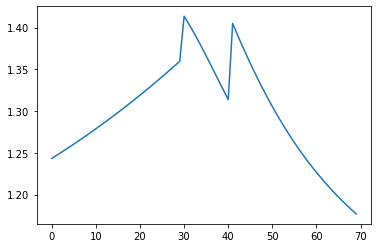

In [ ]:
%matplotlib inline

plt.plot([meshes[t].hes[last_flipped_edge[30]].rest for t in range(70)])

<IPython.core.display.Javascript object>


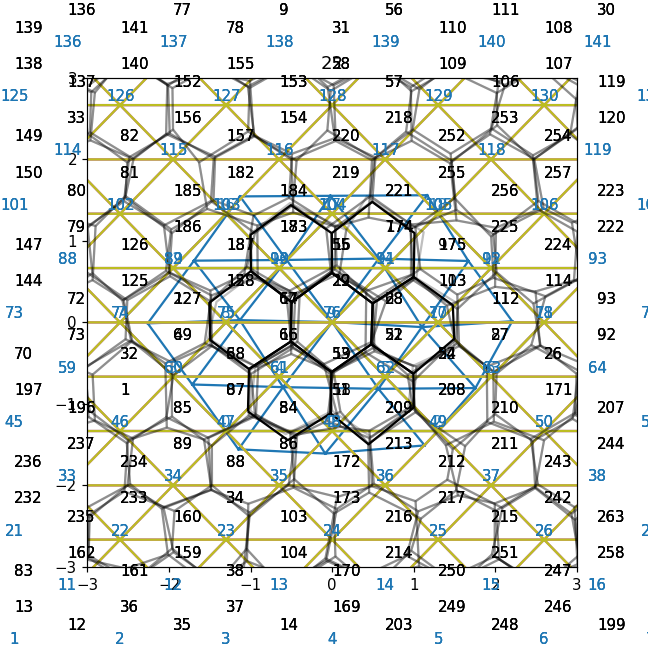

interactive(children=(IntSlider(value=99, description='i', max=199), Output()), _dom_classes=('widget-interact…

In [ ]:
#| notest
%matplotlib notebook

# Plotting function for slider plot
# using the notebook plot mode gives smoother results. still not completely optimize but whatever

fig = plt.figure(figsize=(6,6))
def plot_mesh(i):
    plt.cla()
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot()
    meshes[i].triplot()
    plt.title(i)
    if last_flipped_edge[i] != -1:
        he = meshes[i].hes[last_flipped_edge[i]]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        plt.plot(*line.T, c="r")
    
widgets.interact(plot_mesh, i=(0, n_steps-1, 1));

In [ ]:
%%time
#| notest
%matplotlib inline

## Now let's also save it als HTML5 animation - can take a bit of time due to inefficiency

# create the figure and axes objects
fig = plt.figure(facecolor="white")
# snimation parameters
nframes, frame_dt = n_steps, 200  # Delay between frames in milliseconds

# function that draws each frame of the animation
def animate_meshes(n):
    plt.cla()
    plt.xlim([-8, 8])
    plt.ylim([-6, 6])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title('Triangle-based shape tensor,\nregularization=per-cell area.')
    meshes[n].cellplot()
    meshes[n].triplot()
    if last_flipped_edge[n] != -1:
        he = meshes[n].hes[last_flipped_edge[n]]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        plt.plot(*line.T, c="r")
    if n == nframes-1:
        plt.close()

# run the animation
anim = animation.FuncAnimation(fig, animate_meshes, frames=nframes, interval=frame_dt, repeat=False)
anim.save('plots/cell_shape_animation_regularization_small_metric.mp4', fps=4,)
#extra_args=['-vcodec', 'libx264'])

CPU times: user 22.8 s, sys: 455 ms, total: 23.2 s
Wall time: 23.4 s


## Old code and simulations

In [ ]:
# | export

@patch
def get_primal_energy_fct_vertices(self: HalfEdgeMesh, mod_bulk=1, mod_shear=1e-3, angle_penalty=1e2,
                                   metric=False, oriented=False, rest_shape=None,
                                   regularization="per-cell", 
                                   reg_bulk=0, reg_shear=0, A0=sqrt(3)/2, P0=2*sqrt(3)):
    """Get function to compute primal energy from primal vertices."""
    if rest_shape is None:
        rest_shape = np.eye(2) if metric else 2*np.eye(2)

    # stuff for the shape tensor energy
    face_list = []
    rest_shapes = []
    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    face_key_dict[None] = None
    reference_edges = []
    
    # we want to also check the orientation of each edge. compare to connectors of tri centroids
    for fc in self.faces.values():
        neighbors = [he.twin.face for he in fc.hes]
        if not (None in neighbors):
            face_list.append(anp.array([face_key_dict[x._fid] for x in neighbors]
                                       +[face_key_dict[fc._fid]]))
            reference_edges.append([x.dual_coords-fc.dual_coords for x in neighbors])
    face_list = anp.array(face_list).T
    n_faces = len(self.faces)
    reference_edges = anp.array(reference_edges).transpose((1,0,2))
    reference_edges = (reference_edges.T / np.linalg.norm(reference_edges, axis=-1).T).T

    # stuff for the vertex-energy-based regularization
    cell_list = []
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            cell_list.append(anp.array([face_key_dict[fc._fid] for fc in neighbors]))
    bdry_faces = anp.array([face_key_dict[fc] for fc in get_boundary_faces(self)])
    
    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]]
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)    
    center = anp.mean([fc.dual_coords for fc in self.faces.values()], axis=0)
    
    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        pts = anp.stack([x, y], axis=-1)
        
        # shape energy - can be either vertex style or shape tensor based
        E_shape = 0
        edges = anp.stack([pts[a]-pts[face_list[3]] for a in face_list[:3]])
        # get orientations and lengths of edges
        orientations = anp.sign(anp.einsum("efi,efi->ef", edges, reference_edges))
        lengths = anp.linalg.norm(edges, axis=-1)
        if metric and oriented:
            oriented_edges = (edges.T*orientations.T).T
        elif metric and (not oriented):
            oriented_edges = edges
        elif (not metric) and oriented:
            oriented_edges = (edges.T*orientations.T/lengths.T).T
        elif (not metric) and (not oriented):
            oriented_edges = (edges.T/lengths.T).T        
        tensors = 2*anp.einsum('efi,efj->fij', edges, oriented_edges) - rest_shape
        E_shape = (mod_shear*anp.sum(tensors**2)
                   + mod_bulk*anp.sum((tensors[:,0,0]+tensors[:,1,1])**2))
        
        # regularize with the vertex model energy
        #"""
        E_vertex = 0
        if regularization == "per-cell":
            if reg_bulk > 0 or reg_shear > 0:
                for cll in cell_list:
                    poly = anp.stack([x[cll], y[cll]], axis=-1)
                    E_vertex = (E_vertex+reg_bulk*(polygon_area(poly)-A0)**2
                                + reg_shear*(polygon_perimeter(poly)-P0)**2)
        elif regularization == "total-area":
            poly = anp.stack([x[bdry_faces], y[bdry_faces]], axis=-1)
            area = polygon_area(poly)
            E_vertex = reg_bulk*(area-len(cell_list)*A0)**2
        #"""
        # angle penalty
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]]
        e_primal = (e_primal.T/anp.linalg.norm(e_primal, axis=-1)).T
        E_angle = angle_penalty * anp.mean(anp.einsum('ei,ei->e', e_primal, e_dual)**2)
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        
        return E_shape + E_angle + E_vertex #+ E_trans
    
    return get_E, agrad(get_E)

In [ ]:

##corrected centroid construction still no good
#| export

@patch
def get_primal_energy_fct_vertices(self: HalfEdgeMesh, mod_bulk=1, mod_shear=1e-3, angle_penalty=1e2,
                                   rest_shape=None, reg_bulk=0, A0=sqrt(3)/2,
                                   max_valence=10,):
    """Get function to compute primal energy from primal vertices."""
    if rest_shape is None:
        rest_shape = np.eye(2) if metric else 2*np.eye(2)

    # stuff for the shape tensor energy
    face_list = []    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    face_key_dict[None] = None
    reference_edges = []
    for fc in self.faces.values():
        neighbors = [he.twin.face for he in fc.hes]
        if not (None in neighbors):
            face_list.append(anp.array([face_key_dict[x._fid] for x in neighbors]
                                      +[face_key_dict[fc._fid]]))
            # reference edges absed on centroid connector
            centroid = np.mean([x.vertices[0].coords for x in fc.hes], axis=0) 
            reference_edges.append([np.mean([x.vertices[0].coords for x in fcfc.hes], axis=0)-centroid
                                    for fcfc in neighbors])
    face_list = anp.array(face_list).T
    n_faces = len(self.faces)
    reference_edges = anp.array(reference_edges).transpose((1,0,2))

    # stuff for the vertex-energy-based regularization
    cell_list = []
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            cell = [face_key_dict[fc._fid] for fc in neighbors]
            try:
                cell = anp.pad(cell, (0, max_valence-len(cell)), mode="edge")
            except ValueError:
                print(f"celll with more than {max_valence} nghbs, increase max_valence")
            cell_list.append(cell)
    cell_list = anp.array(cell_list)
    
    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]]
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)
    
    # breaking translational invariance.
    center = anp.mean([v.coords for v in self.vertices.values()], axis=0)
    
    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        pts = anp.stack([x, y], axis=-1)
        # shape energy - can be either vertex style or shape tensor based
        edges = anp.stack([pts[a]-pts[face_list[3]] for a in face_list[:3]])
        lengths = anp.linalg.norm(edges, axis=-1)
        orientations = anp.sign(anp.einsum("efi,efi->ef", edges, reference_edges))
        units = (orientations.T*edges.T/lengths.T).T
        #units = (edges.T/lengths.T).T        
        tensors = 2*anp.einsum('efi,efj->fij', edges, units) - rest_shape
        E_shape = (mod_shear*anp.sum(tensors**2)
                   + mod_bulk*anp.sum((tensors[:,0,0]+tensors[:,1,1])**2))
        # regularize with the vertex model energy
        poly = anp.stack([[x[i], y[i]] for i in cell_list.T]) # shape (max_valence, 2, n_cells)
        E_vertex = reg_bulk*anp.sum((polygon_area(poly)-A0)**2)
        # angle penalty
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]]
        e_primal = (e_primal.T/anp.linalg.norm(e_primal, axis=-1)).T
        E_angle = angle_penalty * anp.mean(anp.einsum('ei,ei->e', e_primal, e_dual)**2)
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        
        return  E_angle + E_shape + E_vertex + E_trans
    
    return get_E, agrad(get_E)